# Deadsea seascrolls training

In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
from torch.utils.data import DataLoader

from monai.networks.nets import UNETR
from monai.data import CacheDataset, Dataset, list_data_collate
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    ScaleIntensityd,
    EnsureTyped,
    RandAffined,
    RandGaussianNoised,
    RandCoarseDropoutd,
    ThresholdIntensityd,
)
import os
import numpy as np
import matplotlib.pyplot as plt
import wandb 

# ensure is in parent directory
try:
    print(os.getcwd())
    os.chdir("../../rug-hr/")
    print(os.getcwd())
except:
    pass

c:\Users\mo\Documents\Organisations\RUG\rug-hr\experiments
c:\Users\mo\Documents\Organisations\RUG\rug-hr


### Setting up the experiment

In [2]:
SPATIAL_SIZE = [256, 256]
SPATIAL_ALIAS = "x".join([str(x) for x in SPATIAL_SIZE])
VERSION = "v1"
ALIAS = "dss"
MODEL_OUTPUT_NAME = f"seglm-{VERSION}-{SPATIAL_ALIAS}-{ALIAS}.pt"

config = {
    "epochs": 200,
    "batch_size": 4,
    "learning_rate": 1e-4,
    "architecture": "UNETR",
    "spatial_size": SPATIAL_SIZE,
    "splits": [0.8, 0.2],
    "model_output_name": MODEL_OUTPUT_NAME,
    "description": "Hebrew UNETR trained on artificial seascrolls dataset",
    "pretrained_model": "artifacts/" + MODEL_OUTPUT_NAME,
    "dataset": "dss_corrupted",
    "dataset_benchmark": "dss_benchmark",
    "model_dir": "artifacts"
}

assert sum(config["splits"]) == 1.0, "Splits must sum to 1.0"

def init_experiment(config=config):
    wandb.init(
        project="handwriting-recognition-seascrolls",
        config=config,
    )

def terminate_experiment():
    wandb.finish()

def log(data):
    wandb.log(data)

# print summary
print("Configuration:")
print("Output model name: ", config["model_output_name"])
print("Using model: ", config["architecture"])
print("Using dataset: ", config["dataset"])
print("Using benchmark dataset: ", config["dataset_benchmark"])
print("Using spatial size: ", config["spatial_size"])
print("Using splits: ", config["splits"])
print("Using learning rate: ", config["learning_rate"])
print("Using batch size: ", config["batch_size"])
print("Using epochs: ", config["epochs"])
print("Using pretrained model: ", config["pretrained_model"])

Configuration:
Output model name:  seglm-v1-256x256-dss.pt
Using model:  UNETR
Using dataset:  dss_corrupted
Using benchmark dataset:  dss_benchmark
Using spatial size:  [256, 256]
Using splits:  [0.8, 0.2]
Using learning rate:  0.0001
Using batch size:  4
Using epochs:  200
Using pretrained model:  artifacts/seglm-v1-256x256-dss.pt


### Setting up the data

In [3]:
# Load paths
splits = config.get("splits")
training_dataset = config.get("dataset")
benchmark_dataset = config.get("dataset_benchmark")
fraction = 1

print(f"Training on {training_dataset} and benchmarking on {benchmark_dataset} with fraction {fraction}")


train_images = sorted(glob(os.path.join("./datasets", f"{training_dataset}/Raw/*")))
train_segs = sorted(glob(os.path.join("./datasets", f"{training_dataset}/Mutated/*")))
train_images = train_images[:int(len(train_images)*fraction)]
train_segs = train_segs[:int(len(train_segs)*fraction)]

test_images = sorted(glob(os.path.join("./datasets", f"{benchmark_dataset}/Raw/*")))
test_segs = sorted(glob(os.path.join("./datasets", f"{benchmark_dataset}/Mutated/*")))

# Training and validation split
split_i = int(len(train_images)*splits[0])
train_files = [{"img": image_name, "seg": seg_name} for image_name, seg_name in zip(train_images[:split_i], train_segs[:split_i])]
val_files = [{"img": image_name, "seg": seg_name} for image_name, seg_name in zip(train_images[split_i:], train_segs[split_i:])]
test_files = [{"img": image_name, "seg": seg_name} for image_name, seg_name in zip(test_images, test_segs)]

print(f"N_train = {len(train_files)}; N_val = {len(val_files)}; N_test = {len(test_files)}")

Training on dss_corrupted and benchmarking on dss_benchmark with fraction 1
N_train = 6553; N_val = 1639; N_test = 512


#### Transformations
The data is transformed as follows:
- A channel is added
- Randomly intensity scale
- Randomly crop with given spatial size
- Random affine transformation and shearing

In [4]:
# Create transformations
spatial_size = config.get("spatial_size")

augmentation_transforms = [
    RandAffined(
        keys=["img", "seg"],
        shear_range=0.3,
        mode=("bilinear", "nearest"),
        prob=0.2,
        padding_mode="zeros",
    ),
    RandGaussianNoised(
        keys=["img"],
        prob=0.2,
        mean=0.0,
        std=0.2
    ),
    RandCoarseDropoutd(
        keys=["img"],
        holes=512,
        spatial_size=(16, 16),
        max_holes=512,
        prob=1,
        fill_value=0,
    ),
    RandCropByPosNegLabeld(
        keys=["img", "seg"],
        label_key="seg",
        spatial_size=spatial_size,
        pos=1,
        neg=1,
        num_samples=4,
        image_key="img",
        image_threshold=0,
    ),
    ScaleIntensityd(keys=["img"]),
]

train_transforms = Compose([
    LoadImaged(keys=["img", "seg"]),
    AddChanneld(keys=["img", "seg"]),
    ThresholdIntensityd(keys=["img"], threshold=1e-4, above=False, cval=1.0),
    ScaleIntensityd(keys=["img"]),
    *augmentation_transforms,
    ScaleIntensityd(keys=["img"]),
    EnsureTyped(keys=["img", "seg"]),
])

val_transforms = Compose([
    LoadImaged(keys=["img", "seg"]),
    AddChanneld(keys=["img", "seg"]),
    ThresholdIntensityd(keys=["img"], threshold=1e-4, above=False, cval=1.0),
    ScaleIntensityd(keys=["img"]),
    EnsureTyped(keys=["img", "seg"]),
])

c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\monai\utils\deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


torch.Size([256, 256]) tensor(0.) tensor(1.)
torch.Size([256, 256]) tensor(0.) tensor(11.)


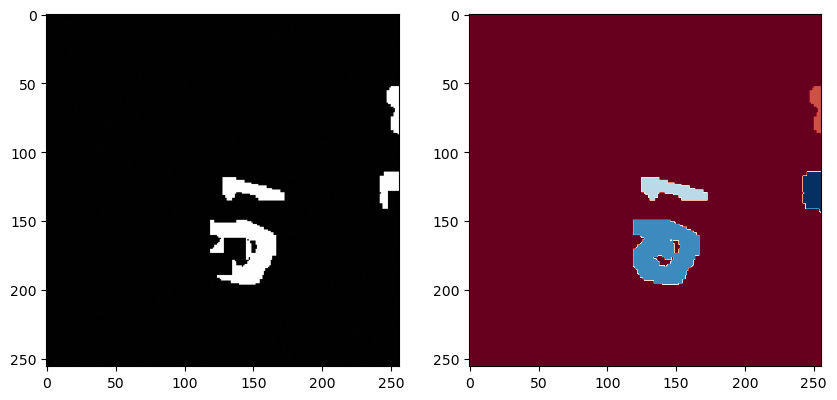

In [5]:
# test train tansform on small sample
choose = np.random.choice(len(train_files))
cropped_sample = train_transforms(train_files[choose])[0]
original = cropped_sample["img"][0, :, :]
label = cropped_sample["seg"][0, :, :]
print(original.shape, original.min(), original.max())
print(label.shape, label.min(), label.max())

# subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original[:, :], cmap="gray")
ax[1].imshow(28-label[:, :], cmap="RdBu_r")
plt.show()

#### Load the dataset

In [6]:
train_loader = DataLoader(
    CacheDataset(data=train_files, transform=train_transforms, cache_rate=0.2),
    shuffle=True,
    batch_size=config.get("batch_size"), 
    num_workers=4, 
    pin_memory=True,
    collate_fn=list_data_collate,
)

val_loader = DataLoader(
    Dataset(data=val_files, transform=val_transforms),
    batch_size=config.get("batch_size"), 
    num_workers=4, 
    pin_memory=True
)

test_loader = DataLoader(
    Dataset(data=test_files, transform=val_transforms),
    batch_size=config.get("batch_size"),
    num_workers=4,
    pin_memory=True
)

Loading dataset: 100%|██████████| 1310/1310 [00:22<00:00, 58.30it/s]


### Training experiment execution

In [7]:

from modules.segnet import SEGNET
import torch

print("device name", torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_output_name = config.get("model_output_name")

model = UNETR(
    in_channels=1,
    out_channels=28,
    img_size=spatial_size,
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.3,
    spatial_dims=2,
).to(device)

net = SEGNET(
    model_name=model_output_name,
    device=device, 
    load=False,
    model=model,
    img_size=spatial_size
)

pre_trained_model = config.get("pretrained_model")
if pre_trained_model:
    try:
        net.load_model(pre_trained_model)
        print("model loaded")
    except:
        print("could not load model")

# print number of trainable parameters
print("number of trainable parameters", sum(p.numel() for p in model.parameters() if p.requires_grad))

device name NVIDIA GeForce RTX 3090
model loaded
number of trainable parameters 87315836


In [8]:
init_experiment(config)
train_loss, test_loss, metrics = net.train(
    trainloader=train_loader, 
    valloader=val_loader,
    log=log, 
    epochs=config.get("epochs"), 
    learning_rate=config.get("learning_rate"), 
    optimizer_name="adam", 
    schedule=False,
)
terminate_experiment()

2023-05-28 15:28:38,262 - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: massaf (rug-ai-group). Use `wandb login --relogin` to force relogin


epochs=200; N=6553; batches=1639; learning_rate=0.0001


  0%|          | 0/410 [00:00<?, ?it/s]c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\monai\data\__init__.py:120: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  t = cls([], dtype=storage.dtype, device=storage.device)
  1%|          | 4/410 [00:10<17:54,  2.65s/it]

In [ ]:
# load the best model
net.load_model(config.get("model_output_name"));

(1512, 1024)


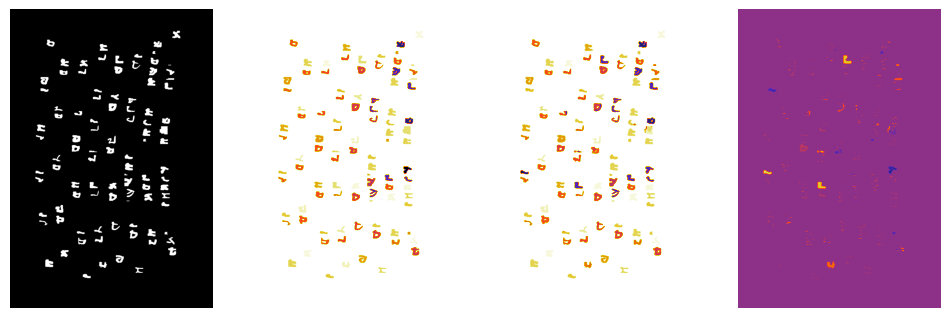

In [ ]:
choice = np.random.choice(len(test_files))
sample = val_transforms(test_files[choice])
x, y = sample["img"], sample["seg"]
x.shape

# Predict
with torch.no_grad():
    yhat = x.cuda()
    yhat = torch.unsqueeze(yhat, 0)
    yhat = net.infere(yhat)
    yhat = torch.squeeze(yhat, 0)
    yhat = torch.argmax(yhat, dim=0)
    yhat = yhat.cpu().numpy()
    
    print(yhat.shape)

diff = yhat - y.cpu().numpy().squeeze(0)

# Plot original, ground truth and prediction
fig, axes = plt.subplots(1, 4, figsize=(12, 8))
axes[0].imshow(x[0, :, :], cmap="gray")
axes[0].axis("off")
axes[1].imshow(28 - y[0, :, :], cmap="CMRmap")
axes[1].axis("off")
axes[2].imshow(28 - yhat, cmap="CMRmap")
axes[2].axis("off")
axes[3].imshow(diff, cmap="CMRmap")
axes[3].axis("off")
plt.show()


In [ ]:
net.validate(test_loader)

  0%|          | 0/128 [00:05<?, ?it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\torch\utils\data\dataloader.py:1132 in       │
│ _try_get_data                                                                                    │
│                                                                                                  │
│   1129 │   │   # Returns a 2-tuple:                                                              │
│   1130 │   │   #   (bool: whether successfully get data, any: data if successful else None)      │
│   1131 │   │   try:                                                                              │
│ ❱ 1132 │   │   │   data = self._data_queue.get(timeout=timeout)                                  │
│   1133 │   │   │   return (True, data)                                                           │
│   1134 │   │   except Exception as e:                                                            │
│   1135 │   │   │   # At timeout and error, we manually check whether any worker has              │
│                                                                                                  │
│ c:\Users\mo\anaconda3\envs\ml_env\lib\queue.py:179 in get                                        │
│                                                                                                  │
│   176 │   │   │   │   while not self._qsize():                                                   │
│   177 │   │   │   │   │   remaining = endtime - time()                                           │
│   178 │   │   │   │   │   if remaining <= 0.0:                                                   │
│ ❱ 179 │   │   │   │   │   │   raise Empty                                                        │
│   180 │   │   │   │   │   self.not_empty.wait(remaining)                                         │
│   181 │   │   │   item = self._get()                                                             │
│   182 │   │   │   self.not_full.notify()                                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
Empty

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 net.validate(test_loader)                                                                    │
│   2                                                                                              │
│                                                                                                  │
│ c:\Users\mo\Documents\Organisations\RUG\rug-hr\modules\segnet.py:230 in validate                 │
│                                                                                                  │
│   227 │   │   n = 0                                                                              │
│   228 │   │                                                                                      │
│   229 │   │   with torch.no_grad():                                                              │
│ ❱ 230 │   │   │   for i, batch in tqdm(enumerate(valloader), total=len(valloader)):              │
│   231 │   │   │   │                                                                              │
│   232 │   │   │   │   images, labels = batch["img"].to(self.device), batch["seg"].to(self.devi   │
│   233 │   │   │   │   logits = self.infere(images)                                               │
│                                                                                                  │
│ c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\tqdm\std.py:1178 in __iter__   